In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm
import random

In [2]:
from common import get_data, get_freq_data, signal_cyclic_shift, generate_multi_signal

In [6]:
X_origin, y_origin = get_data(data_path='./data/shashlik_61_pulses.txt')

In [10]:
X_one_signal, y_one_signal = get_data('./data/shashlik_61_pulses.txt', is_one_signal=True)
ARGMIN_DISTR = np.argmin(X_one_signal, axis=1)

In [11]:
def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    X = []
    y = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha,\
                                           argmin_distr=ARGMIN_DISTR)
        X.append(signal['multi_impulse'])
        y.append(alpha/(1+alpha)) 

   
    X = np.array(X)
    y = np.array(y)
   
    if to_print:
#         print("X positive shape:", X_positive.shape)
#         print("y positive shape:", y_positive.shape)
#         print("X negative shape:", X_negative.shape)
#         print("y negative shape:", y_negative.shape)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

    return X, y

In [12]:
# alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.01)])

alpha_range = np.array([10**i for i in np.arange(0, 3, 0.05)])
tau_range = np.arange(-100, 101, 1)

In [13]:
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=len(X_origin), to_print=True)
X = get_freq_data(X, freq=1)

X shape: (7848, 1024)
y shape: (7848,)


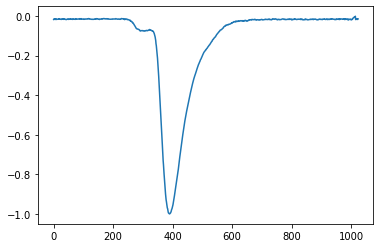

In [14]:
plt.plot(X[0])

In [15]:
from sklearn.preprocessing import normalize

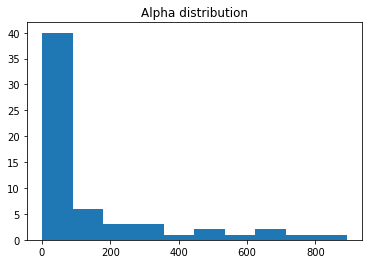

In [16]:
plt.title("Alpha distribution")
plt.hist(alpha_range)
plt.show()

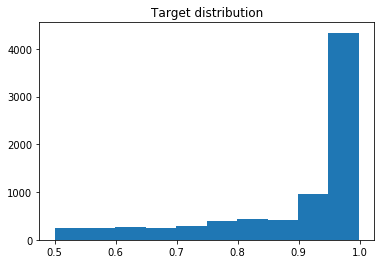

In [17]:
plt.title("Target distribution")
plt.hist(y)
plt.show()

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [19]:
def print_scores():
    for model in models:    
        model_name = type(model).__name__
        print("Regressor:", model_name)
    #         stregr = StackingRegressor(regressors=models, meta_regressor=model)
        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, scoring=scoring, cv=5)

        r2_score_mean = scores['test_r2'].mean()
        r2_score_std = scores['test_r2'].std()
        mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
        mse_score_std = scores['test_neg_mean_squared_error'].std()
        mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
        mae_score_std = scores['test_neg_mean_absolute_error'].std()
        rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
        rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

        cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                          (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
        print("95% confidence interval:")
        for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
            print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
        print('----------------------------------')
    print('____________________________________________________________')
    print()

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
def get_models():
    huber_reg = HuberRegressor(epsilon= 4.927, alpha= 0.00759)
    ridge_reg = linear_model.Ridge(solver='saga', max_iter=5000, alpha= 1)
    lasso_reg = linear_model.Lasso(max_iter=5000, alpha=0.0001, normalize=False)
    dt_reg = tree.DecisionTreeRegressor(min_samples_split=9, min_samples_leaf=6, min_weight_fraction_leaf=0.03, 
                                                                                                 max_features='auto')

    pa_reg = PassiveAggressiveRegressor(C=0.00611, max_iter=2800, tol=5.719679731382862e-05)
    xgb_reg = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)
    return [huber_reg, ridge_reg, lasso_reg, dt_reg,  pa_reg, xgb_reg]

In [22]:
models = get_models()

In [23]:
print_scores()

Regressor: HuberRegressor
95% confidence interval:
r2 score: 0.55867 (+/- 0.02204)
mse score: 0.00832 (+/- 0.00101)
mae score: 0.05979 (+/- 0.00270)
rmse score: 0.09118 (+/- 0.00552)
----------------------------------
Regressor: Ridge
95% confidence interval:
r2 score: 0.58050 (+/- 0.02305)
mse score: 0.00792 (+/- 0.00120)
mae score: 0.05751 (+/- 0.00228)
rmse score: 0.08892 (+/- 0.00679)
----------------------------------
Regressor: Lasso


KeyboardInterrupt: 

### Stacking

In [ ]:
from mlxtend.regressor import StackingRegressor


In [ ]:
for i in range(len(models)):
    models = get_models()
    print("Metaregressor:", type(models[i]).__name__)

    stregr = StackingRegressor(regressors=models, meta_regressor=models[i])
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(stregr, X, y, scoring=scoring, cv=5)

    r2_score_mean = scores['test_r2'].mean()
    r2_score_std = scores['test_r2'].std()
    mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
    mse_score_std = scores['test_neg_mean_squared_error'].std()
    mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
    mae_score_std = scores['test_neg_mean_absolute_error'].std()
    rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
    rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

    cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                      (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
    print("95% confindence interval:")
    for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
        print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
    print('--------------------------------------------------------')

### Let's plot scores for different sampling frequency values

In [24]:
alpha_values = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.1)])
tau_values = range(-25, 30, 5)
freq_values = [1, 25, 50, 60, 75, 85, 100]
# alpha_values = np.around(np.arange(0, 100, 2), decimals=2)

In [25]:
def calculate_scores(X, y, alpha_values, tau_values, data_size=100, freq=1):
    scores_dict = {}    
    model = get_models()[-1]
    X_freq = get_freq_data(X, freq=freq)
    model.fit(X_freq, y)

    for tau in tqdm.tqdm(tau_values):
        scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))
        for alpha in alpha_values:
            X_cur, y_cur = prepare_data(X_origin, y_origin, [tau], [alpha], data_size=data_size)
            X_cur = get_freq_data(X_cur, freq=freq)
            y_pred = model.predict(X_cur)

            scores_dict[tau][alpha] = np.sqrt(mean_squared_error(y_pred, y_cur))

    return scores_dict

In [26]:
def dict_to_arrays(scores_dict):
    x, y, z = [], [], []
    for tau, alpha_dict in scores_dict.items():
        for alpha, score in alpha_dict.items():
            x.append(tau)
            y.append(alpha)
            z.append(score)
            
    return [x, y, z]

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
# matplotlib.use('Qt4Agg')

def plot_score_3d(scores_dict):
    x, y, z = dict_to_arrays(scores_dict)
    alpha_values = list(scores_dict[list(scores_dict.keys())[0]].keys())
    
    fig1 = matplotlib.pyplot.figure(figsize=(7, 5))
    ax1 = Axes3D(fig1)

    ax1.set_yticks(np.log10(alpha_values[::10]))
    ax1.set_yticklabels(alpha_values[::10])

    ax1.set_xlabel(r"${\tau}$", fontsize=15)
    ax1.set_ylabel(r"${\alpha}$", fontsize=15)
    ax1.set_zlabel('Accuracy', fontsize=15)

#     ax1.view_init(30, 150)
    ax1.plot(10*x, np.log10(10*y), 10*z, 'ro', color='b', linewidth=3)

    for angle in range(0, 180):
        ax1.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

    plt.show()

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

VMIN = 0
VMAX = 1.6
STEP = 0.2
ORIGIN_FREQ = 5000

def plot_color_map(scores_dict, alpha_values, tau_values, alpha_freq=10, tau_freq=2, freq=1):
    _, _, z = dict_to_arrays(scores_dict)
    z = np.array(z)
    Z = z.reshape((len(tau_values), len(alpha_values)))

    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.title("RMSE log(alpha), frequency = " + str(int(ORIGIN_FREQ/freq)) + ' [MHZ]')
    plt.xlabel("Two signals ratio", fontsize=12)
    plt.ylabel("Delta t [ns]", fontsize=12)
    plt.xticks([alpha_freq*i for i in range(len(alpha_values[::alpha_freq]))], alpha_values[::alpha_freq])
    plt.yticks([tau_freq*i for i in range(len(tau_values[::tau_freq]))], [0.2*el for el in tau_values[::tau_freq]])

#     im = ax.imshow(Z, interpolation='bilinear', cmap='spring', aspect='auto')
    im = ax.imshow(Z, interpolation='bilinear', cmap='spring', aspect='auto', vmin=VMIN, vmax=VMAX)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

#     plt.colorbar(im, cax=cax)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.arange(VMIN, VMAX, STEP))
    cbar.set_ticklabels(np.round(np.arange(VMIN, VMAX, STEP), decimals=1))
    plt.show()

In [29]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [32]:
freq_values = [5, 10]

In [ ]:
X_origin, y_origin = get_data(data_path='./data/shashlik_61_pulses.txt')
X, y = prepare_data(X_origin, y_origin, tau_values, alpha_values, to_print=False, data_size=int(len(X_origin)))

for freq in freq_values:
    scores_dict = calculate_scores(X, y, alpha_values, tau_values, data_size=1000, freq=freq)
    plot_color_map(scores_dict, alpha_values, tau_values, freq=freq)
    save_obj(scores_dict, 'scores_amplitude_regressor_log_freq=' + str(freq))
#     plot_score_3d(scores_dict)


  9%|▉         | 1/11 [05:32<55:20, 332.05s/it]

### -----------------

In [ ]:
model = get_models()[0]
X_origin, y_origin = get_data()
X, y = prepare_data(X_origin, tau_range, alpha_range, data_size=len(X_origin), to_print=True)
model.fit(X, y)

In [ ]:
plt.hist(y)
plt.show()

In [ ]:
from sklearn.utils import shuffle

def prepare_data(X_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, tau, alpha)['multi']
        
        X.append(signal)
        y.append(np.log10(alpha))
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [ ]:
plt.hist(y)

In [ ]:
X_cur, y_cur = prepare_data(X_origin, [100], [0.5], data_size=100)
y_pred = model.predict(X_cur)

In [ ]:
plt.plot(X_cur[0])

In [ ]:
plt.hist(y_pred)

In [ ]:
mean_absolute_error(y_pred, y_cur)

In [2]:
y_cur

NameError: name 'y_cur' is not defined

In [ ]:
plt.hist(alpha_range)

In [ ]:
y_pred

In [ ]:
y_pred

In [ ]:
model = StackingRegressor(regressors=models, meta_regressor=models[0])
model.fit(X, y)

In [ ]:
alpha_scores = []
alpha_test_range = np.arange(1, 1002, 1)

In [ ]:
for alpha in alpha_test_range:
    X_cur, y_cur = prepare_data(X_origin, tau_range, [alpha], data_size=1000, to_print=False)
    y_pred = model.predict(X_cur)
    alpha_scores.append(mean_absolute_error(y_pred, y_cur))

In [ ]:
np.exp(1)**0.1

In [ ]:
alpha_scores[300]

In [ ]:
alpha_scores[700]

In [ ]:
plt.title("Alpha train uniform distribution")
plt.ylabel("MAE")
plt.xlabel("Alpha")
plt.plot(alpha_scores)
plt.show()

In [ ]:
####